# **AI ENABLED CAR PARKING USING OpenCV**

Objective : Achieve precise vehicle detection and autonomous guidance into parking spaces, establishing a smart parking infrastructure that ensures accuracy and convenience for drivers.


Importing the required libraries

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

To mount Google Drive and to access files and folders within the Colab notebook environment.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# Information about the data set

The dataset for the "AI Enabled Car Parking Using OpenCV" project consists of images of cars captured at a size of 128x128 pixels with RGB color channels.

- **Size of Images**: Each image in the dataset has dimensions of 128x128 pixels.
- **Color Channels**: The images are in RGB format, meaning each pixel has three values representing the intensity of red, green, and blue channels.
- **Total Samples**: There are 381 samples in the training dataset and 164 samples in the test dataset.
- **Labeling**: Each sample is labeled as either "empty" or "occupied" to indicate whether the parking space depicted in the image is vacant or has a car parked in it.
- **Features**: The features of the dataset are the pixel values of the images, representing the visual characteristics of the cars and parking spaces. These features are used by the AI model, likely built with OpenCV and other techniques, to learn patterns and make predictions regarding the occupancy status of parking spaces based on the input images.

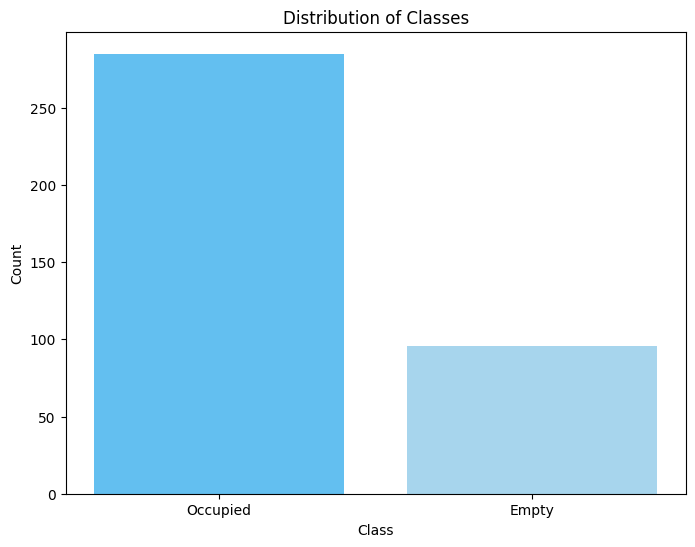

In [3]:
train_data_dir = '/content/drive/MyDrive/AI_Enabled_Car_Parking/CarParking_Dataset/train_data/train'
validation_data_dir = '/content/drive/MyDrive/AI_Enabled_Car_Parking/CarParking_Dataset/train_data/test'
# Distribution of classes
class_counts = [len(os.listdir(os.path.join(train_data_dir, 'occupied'))), len(os.listdir(os.path.join(train_data_dir, 'empty')))]
class_labels = ['Occupied', 'Empty']

plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_counts, color=["#63bff0", "#a7d5ed"])
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


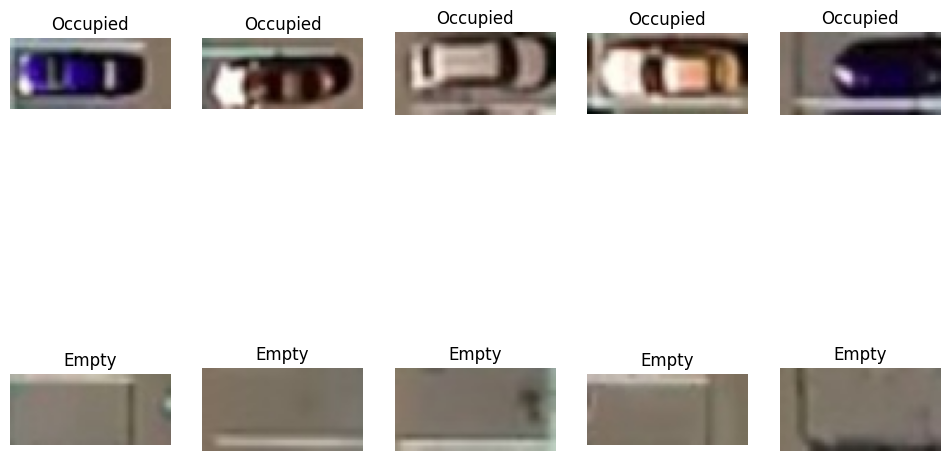

In [4]:
# Display sample images
sample_images_paths = [os.path.join(train_data_dir, 'occupied', img) for img in os.listdir(os.path.join(train_data_dir, 'occupied'))[:5]] + \
                      [os.path.join(train_data_dir, 'empty', img) for img in os.listdir(os.path.join(train_data_dir, 'empty'))[:5]]

plt.figure(figsize=(12, 8))
for i, img_path in enumerate(sample_images_paths):
    plt.subplot(2, 5, i + 1)
    img = plt.imread(img_path)
    plt.imshow(img)
    if i < 5:
        plt.title('Occupied')
    else:
        plt.title('Empty')
    plt.axis('off')
plt.show()


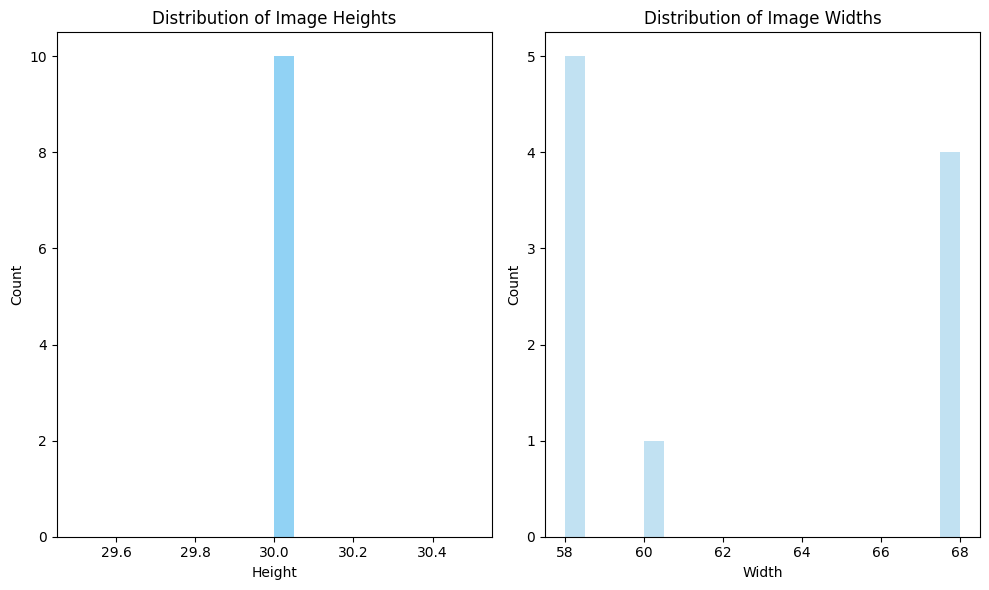

In [5]:
# Image size distribution
image_sizes = []
for img_path in sample_images_paths:
    img = plt.imread(img_path)
    image_sizes.append(img.shape[:2])

image_heights = [size[0] for size in image_sizes]
image_widths = [size[1] for size in image_sizes]

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(image_heights, bins=20, color="#63bff0" , alpha=0.7)
plt.title('Distribution of Image Heights')
plt.xlabel('Height')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(image_widths, bins=20, color="#a7d5ed", alpha=0.7)
plt.title('Distribution of Image Widths')
plt.xlabel('Width')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [6]:
def count_files(directory):
    return sum([len(files) for _, _, files in os.walk(directory)])


files_train = count_files(train_data_dir)
files_validation = count_files(validation_data_dir)

print("No.of Training samples : {}".format(files_train))
print("No.of Testing samples : {}".format(files_validation) )


No.of Training samples : 381
No.of Testing samples : 164


## Model Parameters :

- Batch Size: The number of samples processed before the model is updated.
- Epochs: The number of times the entire dataset is passed forward and backward through the neural network.

In [7]:
# Model parameters
img_width, img_height = 128, 128
train_data_dir = "/content/drive/MyDrive/AI_Enabled_Car_Parking/CarParking_Dataset/train_data/train"
validation_data_dir = "/content/drive/MyDrive/AI_Enabled_Car_Parking/CarParking_Dataset/train_data/test"
nb_train_samples = files_train
nb_validation_samples = files_validation
batch_size = 32
epochs = 5

This code initializes the VGG16 model pre-trained on the ImageNet dataset, removes the fully connected layers (top layers) to keep only the convolutional base, and freezes the first 10 layers to prevent their weights from being updated during training, effectively using them as feature extractors without modification.

In [8]:
# Loading pre-trained VGG16 model
base_model = applications.VGG16(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))

# Freezing layers in the base model
for layer in base_model.layers[:10]:
    layer.trainable = False


58889256/58889256 [==============================] - 0s 0us/step


This code adds a custom dense layer for binary classification on top of the pre-trained VGG16 model. It uses global average pooling to reduce the spatial dimensions of the features from the base model, followed by a dense layer with a softmax activation function, outputting probabilities for two classes (empty and occupied). Finally, it constructs a new model with the modified input and output layers.

In [9]:
# Adding custom dense layer for binary classification
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(units=2, activation='softmax')(x)
model = Model(base_model.input, x)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

This code compiles the model with the Adam optimizer using a learning rate of 0.0001, categorical cross-entropy as the loss function, and accuracy as the evaluation metric.

In [11]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

This code sets up data augmentation for both the training and testing datasets using the ImageDataGenerator class from Keras. Augmentation techniques include rescaling pixel values, horizontal flipping, adjusting zoom, width and height shifting, and rotation by a maximum of 5 degrees.

In [12]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    fill_mode="nearest",
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=5)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    fill_mode="nearest",
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=5)


This code creates data generators for both the training and validation datasets. Images are loaded from directories `train_data_dir` and `validation_data_dir`, resized to the specified target size of 128x128 pixels, and classified using categorical labels. The batch size specified earlier is used to generate batches of data during training and validation.

In [13]:
# Creating data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical")

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    class_mode="categorical")

Found 381 images belonging to 2 classes.
Found 164 images belonging to 2 classes.


This code sets up model checkpointing and early stopping callbacks to monitor validation accuracy during training. The `ModelCheckpoint` callback saves the model weights to "car1.h5" whenever there is an improvement in validation accuracy, while the `EarlyStopping` callback terminates training if there is no improvement in validation accuracy for more than 10 epochs. The training process is initiated using the `fit_generator` method, utilizing the previously defined data generators for training and validation datasets, with specified number of epochs, and the callbacks for checkpointing and early stopping.

In [14]:
# Model training
checkpoint = ModelCheckpoint("car1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=1, mode='auto')

def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

history_object = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint, early, lr_callback],
)

<ipython-input-14-efb38b9e3f3a>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_object = model.fit_generator(


Epoch 1/5
12/12 [==============================] - ETA: 0s - loss: 0.3145 - accuracy: 0.8819 

12/12 [==============================] - 226s 19s/step - loss: 0.3145 - accuracy: 0.8819 - val_loss: 0.1651 - val_accuracy: 0.9207 - lr: 1.0000e-04
Epoch 2/5
12/12 [==============================] - ETA: 0s - loss: 0.1085 - accuracy: 0.9554 

12/12 [==============================] - 180s 15s/step - loss: 0.1085 - accuracy: 0.9554 - val_loss: 0.1648 - val_accuracy: 0.9207 - lr: 1.0000e-04
Epoch 3/5
12/12 [==============================] - ETA: 0s - loss: 0.0903 - accuracy: 0.9659 

12/12 [==============================] - 187s 16s/step - loss: 0.0903 - accuracy: 0.9659 - val_loss: 0.1704 - val_accuracy: 0.9146 - lr: 1.0000e-04
Epoch 4/5
12/12 [==============================] - ETA: 0s - loss: 0.0402 - accuracy: 0.9843 

12/12 [==============================] - 194s 16s/step - loss: 0.0402 - accuracy: 0.9843 - val_loss: 0.1896 - val_accuracy: 0.9207 - lr: 1.0000e-04
Epoch 5/5
12/12 [==============================] - ETA: 0s - loss: 0.0819 - accuracy: 0.9738 

12/12 [==============================] - 187s 16s/step - loss: 0.0819 - accuracy: 0.9738 - val_loss: 0.1091 - val_accuracy: 0.9512 - lr: 1.0000e-04


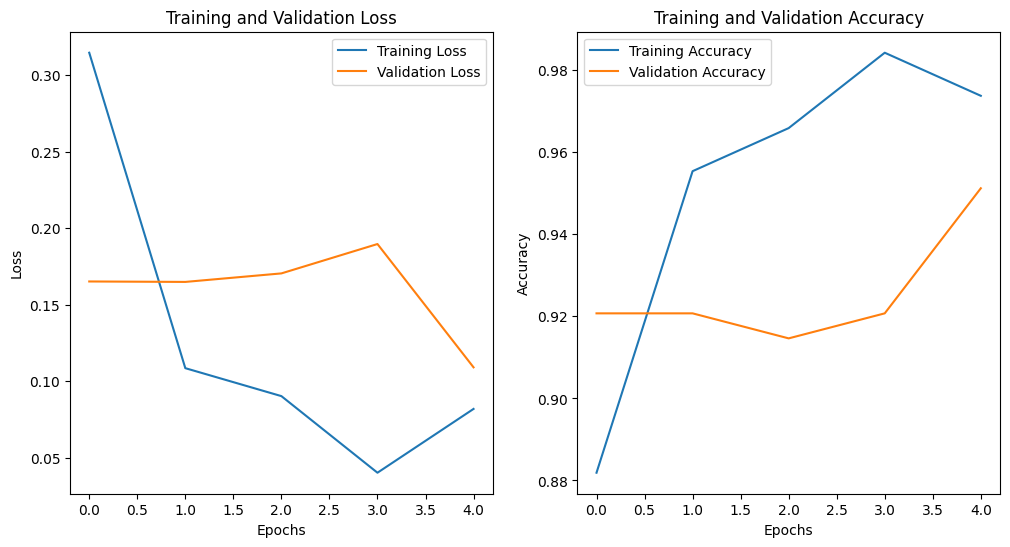

In [15]:
# Plotting training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_object.history['loss'], label='Training Loss')
plt.plot(history_object.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_object.history['accuracy'], label='Training Accuracy')
plt.plot(history_object.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 6s 6s/step


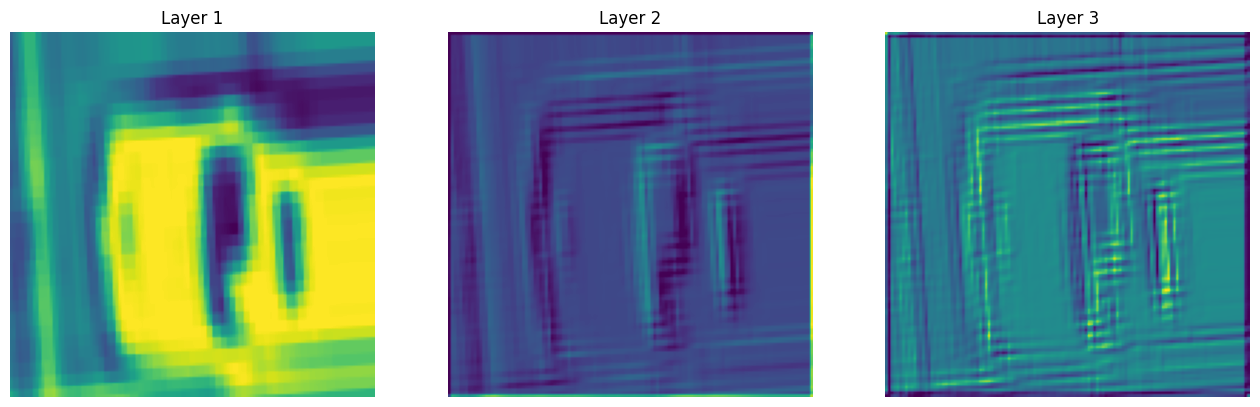

In [16]:
# Get feature maps from intermediate layers
sample_images, sample_labels = next(validation_generator)
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(sample_images)

# Plot feature maps
plt.figure(figsize=(16, 12))
for i in range(3):  # Display feature maps from the first 3 layers
    plt.subplot(1, 3, i+1)
    plt.title(f'Layer {i+1}')
    plt.imshow(activations[i][0, :, :, 0], cmap='viridis')
    plt.axis('off')
plt.show()

This function `prediction(path)` takes an image file path as input, loads the image, resizes it to match the model's input dimensions, converts it to a NumPy array, and scales the pixel values to be between 0 and 1. Then, it makes a prediction using the trained model and prints the predicted class label based on the highest probability.

In [17]:
# Model prediction function
def prediction(path):
    img = tf.keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescaling
    pred = np.argmax(model.predict(img_array))
    print(f"The image belongs to class {pred}")

In [18]:
evaluation_metrics = model.evaluate(validation_generator)
print("Evaluation Metrics:")
print(f"Loss: {evaluation_metrics[0]}")
print(f"Accuracy: {evaluation_metrics[1]}")

6/6 [==============================] - 33s 5s/step - loss: 0.1109 - accuracy: 0.9634
Evaluation Metrics:
Loss: 0.11094529181718826
Accuracy: 0.9634146094322205


In [19]:
# Confusion matrix
print("\nConfusion Matrix:")
validation_generator.reset()
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(validation_generator.classes, y_pred)
print(cm)


Confusion Matrix:
6/6 [==============================] - 33s 5s/step
[[ 8 30]
 [27 99]]


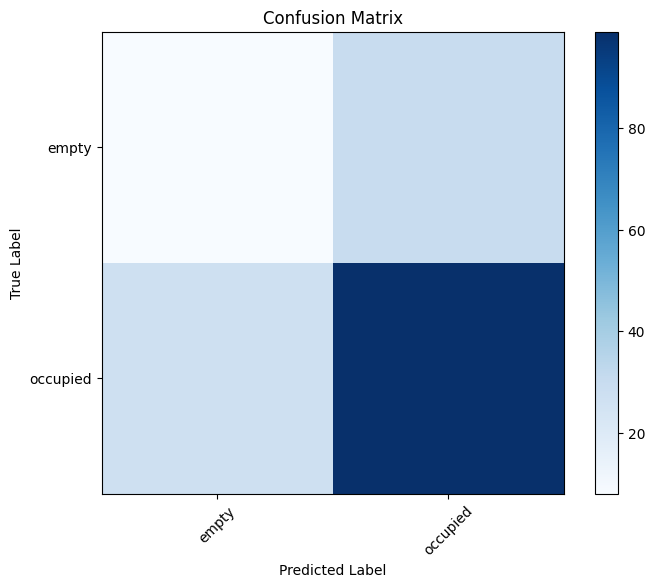

In [20]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(list(validation_generator.class_indices.keys())))
plt.xticks(tick_marks, list(validation_generator.class_indices.keys()), rotation=45)
plt.yticks(tick_marks, list(validation_generator.class_indices.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [21]:
print("\nClassification Report:")
target_names = list(validation_generator.class_indices.keys())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))


Classification Report:
              precision    recall  f1-score   support

       empty       0.23      0.21      0.22        38
    occupied       0.77      0.79      0.78       126

    accuracy                           0.65       164
   macro avg       0.50      0.50      0.50       164
weighted avg       0.64      0.65      0.65       164



1/1 [==============================] - 7s 7s/step


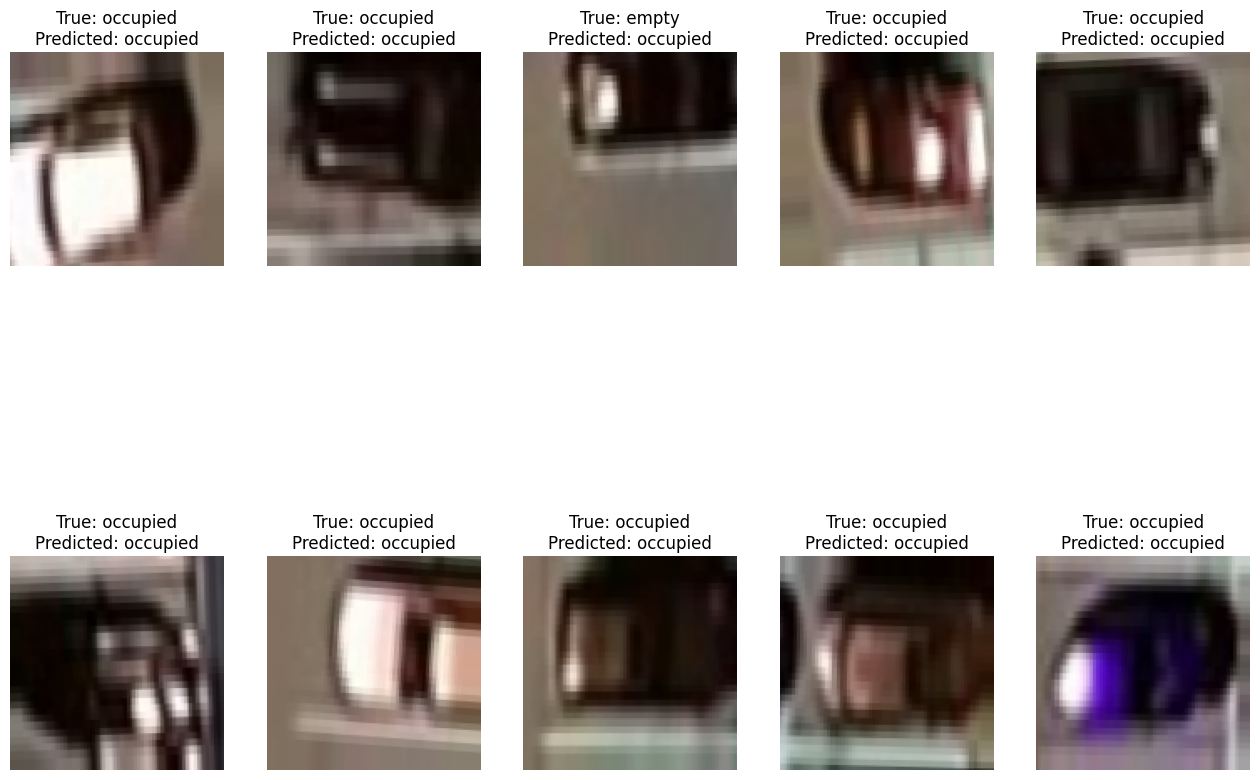

In [22]:
sample_images, sample_labels = next(validation_generator)
sample_predictions = model.predict(sample_images)
sample_predictions_labels = np.argmax(sample_predictions, axis=1)

plt.figure(figsize=(16, 12))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images[i])
    true_label = target_names[np.argmax(sample_labels[i])]
    pred_label = target_names[sample_predictions_labels[i]]
    plt.title(f'True: {true_label}\nPredicted: {pred_label}')
    plt.axis('off')
plt.show()

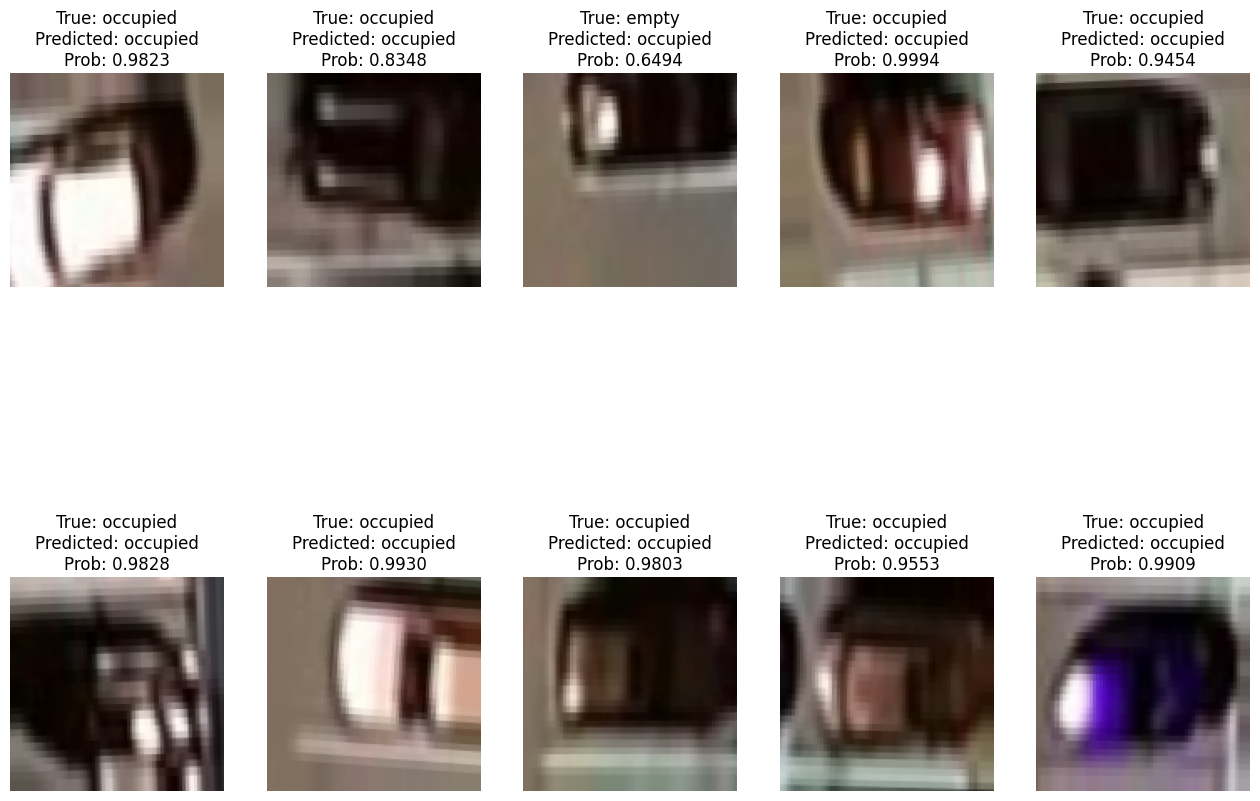

In [23]:
plt.figure(figsize=(16, 12))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images[i])
    true_label = target_names[np.argmax(sample_labels[i])]
    pred_prob = sample_predictions[i]
    pred_label = target_names[sample_predictions_labels[i]]
    plt.title(f'True: {true_label}\nPredicted: {pred_label}\nProb: {pred_prob.max():.4f}')
    plt.axis('off')
plt.show()

In [26]:
# Save the model as a pickle file
import pickle

model_dict = {'model': model.to_json(), 'weights': model.get_weights()}

with open('/content/drive/MyDrive/AI_Enabled_Car_Parking/parkingSlotPosition', 'wb') as f:
    pickle.dump(model_dict, f)